# Time Series Analysis on the max load each day

In [233]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [234]:
def harmonic_approx(x, season_length, coef, intercept=0):
    sum = np.zeros(x.shape) + intercept

    for (i, (c, trig_fun)) in enumerate(zip(coef, itertools.cycle([np.sin, np.cos]))):
        d = i//2+1
        sum += c * trig_fun(x * d * 2*np.pi / season_length)
    
    return sum


def fit_tri(ydata, harmonic_degree, x=None, fit_intercept=False):

    if x is None:
        x = ydata.index #assuming that ydata is a Series

    harmonics = range(1, harmonic_degree+1)

    basis = []
    for multiplier in harmonics:
        basis.append(pd.Series( np.sin(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_sin'))
        basis.append(pd.Series( np.cos(x*multiplier*2*np.pi/season_length), name = f'beta_{multiplier}_cos'))

    trig_basis = pd.concat(basis, axis=1)

    lr = LinearRegression()
    model = lr.fit(trig_basis, ydata)
    if fit_intercept:
        intercept = model.intercept_
    else:
        intercept = 0
    
    approximation_result = harmonic_approx(x, season_length, model.coef_, intercept)

    return (model, approximation_result)


season_length = 365*24

In [235]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
# NF_ORANGE = '#ff5a36'
# NF_BLUE = '#163251'
# Define the colors based on the google presentation for each season.
COLOR_SUMMER = '#f9da21'
COLOR_WINTER = '#70b2b2'
COLOR_AUTUMN = '#9e9e9e'
COLOR_SPRING = '#97be6d'
# cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
cmaps_hex = ['#70b2b2', '#f9da21', '#9e9e9e', '#97be6d', '#f9da21', '#70b2b2']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [236]:
# Load data
df = pd.read_csv("../data/preprocessed/Building_5.csv").astype({'datetime': 'datetime64'})#.set_index('datetime')

## Visualize the time series

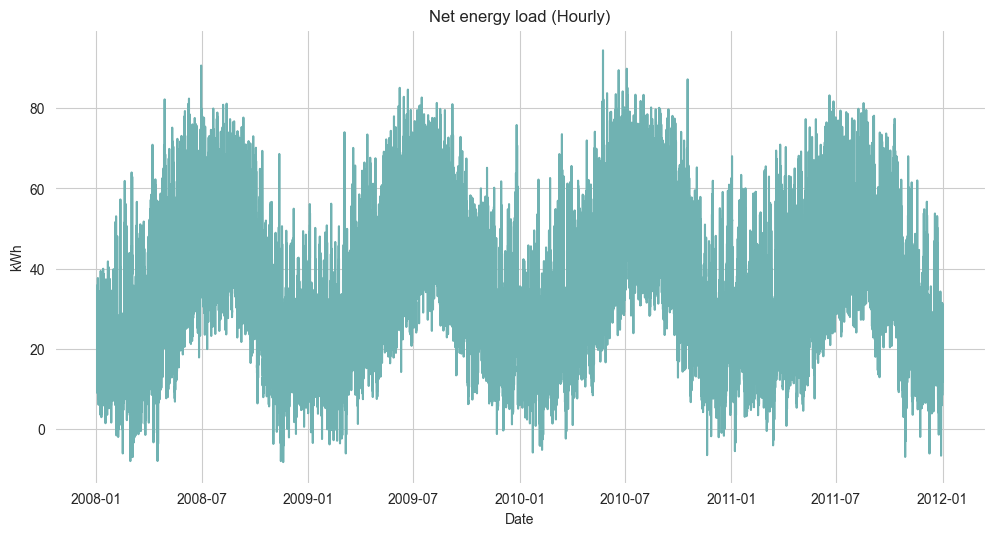

In [237]:
fig, ax = plt.subplots()
sns.lineplot(x='datetime', y = 'net_load_kWh', data=df, ax=ax)
ax.set(title="Net energy load (Hourly)", xlabel='Date', ylabel='kWh');
fig.savefig('../images/Hourly_Net_Load.png', dpi=450)

In [238]:
data_df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    weekofyear = lambda x: x['timestamp'].dt.weekofyear,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)
weekly_data_df = data_df\
    .groupby(['date','year','month','weekofyear','day','dayofyear'], as_index=False)\
    .agg({'net_load_kWh':np.mean})\
    .set_index('date')

In [239]:
weekly_data_df

,year,month,weekofyear,day,dayofyear,net_load_kWh
date,,,,,,
2008-01-02,2008,1,1,2,2,18.441895
2008-01-03,2008,1,1,3,3,17.943457
2008-01-04,2008,1,1,4,4,15.136470
2008-01-05,2008,1,1,5,5,16.540261
2008-01-06,2008,1,1,6,6,21.002734
...,...,...,...,...,...,...
2011-12-27,2011,12,52,27,361,14.230288
2011-12-28,2011,12,52,28,362,13.878224
2011-12-29,2011,12,52,29,363,11.944185


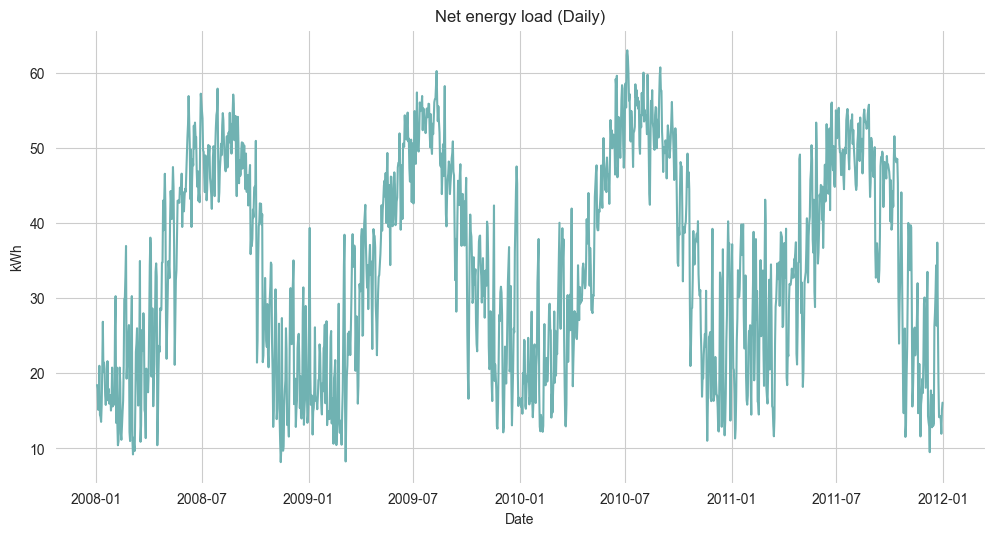

In [240]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y = 'net_load_kWh', data=weekly_data_df, ax=ax)
ax.set(title="Net energy load (Daily)", xlabel='Date', ylabel='kWh');
# fig.savefig('../images/Daily_Net_Load.png', dpi=450)

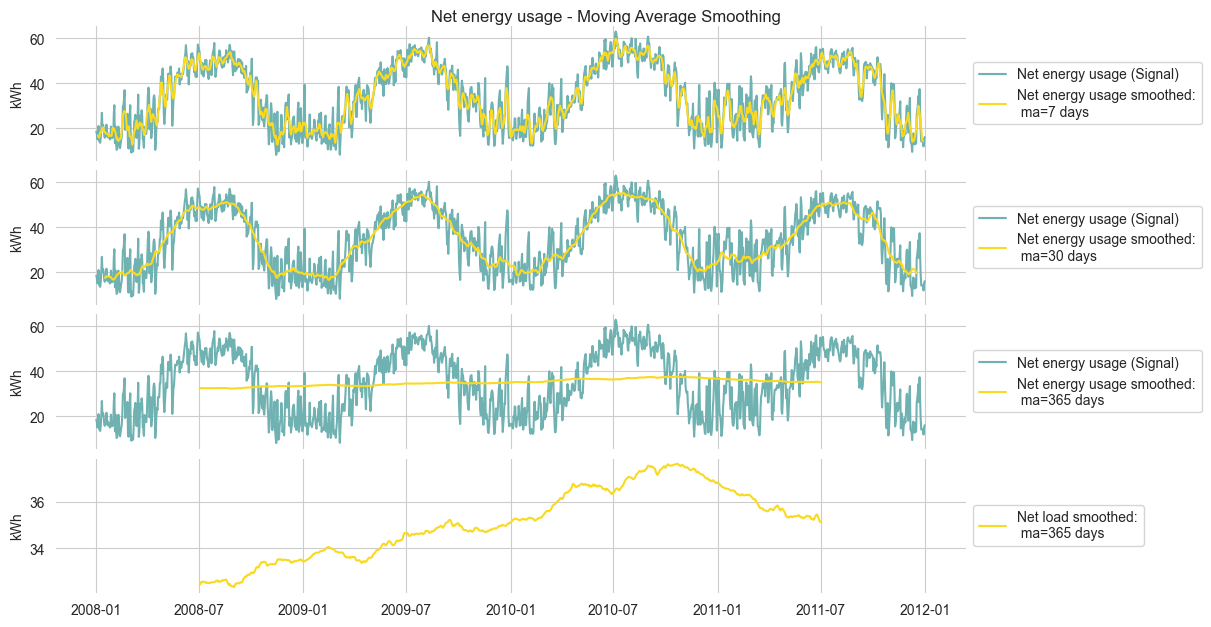

In [241]:
ma = [7, 30, 365]

smooth_daily_data_df = weekly_data_df.reset_index()\
    .assign(date = lambda x:x['date'].transform(pd.to_datetime))

fig, ax = plt.subplots(len(ma)+1, 1,
    constrained_layout=True, sharex=True)
plt.suptitle('Net energy usage - Moving Average Smoothing', y=1.02)

for i, m in enumerate(ma):
    smooth_daily_data_df[f'net_load_ma{m}'] = smooth_daily_data_df['net_load_kWh']\
        .rolling(window=m, center=True).mean()

    sns.lineplot(x='date', y ='net_load_kWh', label = 'Net energy usage (Signal)', 
        data = smooth_daily_data_df, ax=ax[i])
    sns.lineplot(x='date', y =f'net_load_ma{m}',
        label=f'Net energy usage smoothed:\n ma={m} days',
        data = smooth_daily_data_df, color = COLOR_SUMMER, ax=ax[i])
    ax[i].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
    ax[i].set(title='', ylabel='kWh');
sns.lineplot(x='date', y =f'net_load_ma{m}',
    label=f'Net load smoothed:\n ma={m} days',
    data = smooth_daily_data_df, color=sns_c[1], ax=ax[i+1])
ax[i+1].legend(title='', loc='center left', bbox_to_anchor=(1, 0.5))
ax[i+1].set(title='', xlabel='', ylabel='kWh');
fig.savefig('../images/moving_average_smoothing_net_energy_usage.png', dpi=450, bbox_inches='tight')

### Helper functions

In [242]:
def plot_decomposition(seas_decomp_yearly, 
    labels=['Observed data (signal)','Trend (364 days moving average)', 'Seasonality', 'Residual'], file_name=''):
    
    # cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
    sns.set_palette(palette=cmaps_hex)
    sns_c = sns.color_palette(palette=cmaps_hex)

    # Plots:
    fig, ax = plt.subplots(3, 1, constrained_layout=True)

    #Plot Signal
    ax[0].set(title=labels[0], 
            ylabel='kWh')
    seas_decomp_yearly.observed.plot(color=sns_c[0], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[0])
    #Plot Trend
    ax[1].set(title=labels[1], 
            ylabel='kWh')
    seas_decomp_yearly.trend.plot(color=sns_c[1], 
                                linewidth=1,
                                sharex=True,
                                ax=ax[1])
    #Plot Seasonality
    ax[2].set(title=labels[2], 
            ylabel='kWh')
    seas_decomp_yearly.seasonal.plot(
                                    color=sns_c[2], 
                                    linewidth=1,
                                    sharex=True,
                                    ax=ax[2])
    # #Plot residual
    # ax[3].set(title=labels[3], 
    #         ylabel='kWh');
    # ax[3].scatter(
    #     x=seas_decomp_yearly.resid.index,
    #     y=seas_decomp_yearly.resid,
    #     color=sns_c[3],
    #     s=4)
    fig.savefig(file_name, dpi=450, bbox_inches='tight')

def stationarity_test(stock_close_price):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = stock_close_price.rolling(rolling).mean()
    rolling_std_dev = stock_close_price.rolling(rolling).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='#99D04A',label='Original Time Series')
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    if adf_test[1] < 0.05:
        print("Time series is stationary")
    else:
        print("Time series is not stationary")
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    if kpss_test[1] < 0.05:
        print("Time series is not stationary")
    else:
        print("Time series is stationary")
    print('----'*10)

def plot_ts(ts = None, ts_add = None, title ='Time Series', legend=['1']):
    """
    Plots one or two time series in a single plot
    
        Args:
        ts: 1d- or 2d-array of time series. Dimension
            must be (n,) or (n,2)
        title: Title for the time plot.
        legend: list of legend names. If empty no legend.
        
        Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(10, 4))
    plt.plot(ts[:,], color="orange")
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color="blue")
    if len(legend) > 0:
        plt.legend(legend)
    plt.show()

## Decomposition of the time series (daily)

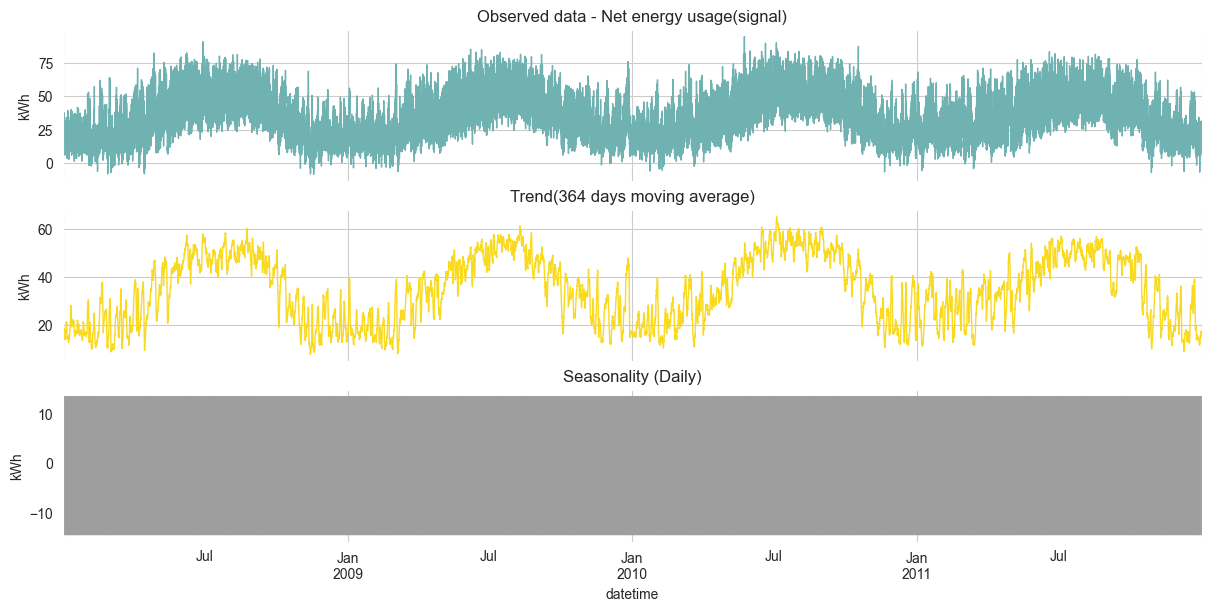

In [243]:
# Decomposition weekly (7 days)
decomp_weekly = seasonal_decompose(df.set_index('datetime')['net_load_kWh'], model='add', 
    two_sided = True,period=24)
# decomp_weekly.plot();
# plot_decomposition(decomp)
plot_decomposition(decomp_weekly, labels = ['Observed data - Net energy usage(signal)',
                    'Trend(364 days moving average)', 'Seasonality (Daily)',
                    'Residual'],
                    file_name = '../images/decomposition_daily_net_energy_usage.png')

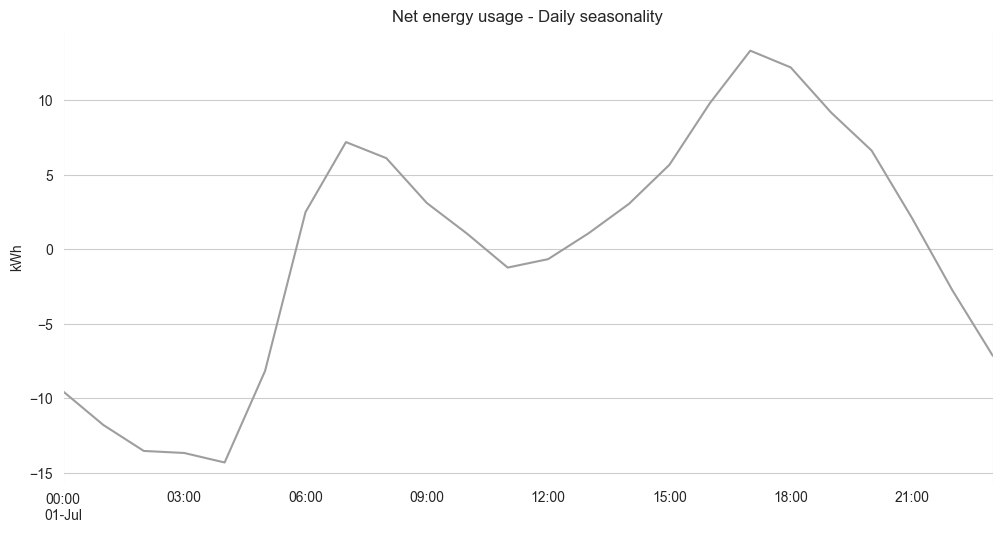

In [244]:
fig, ax = plt.subplots()
ax = decomp_weekly.seasonal[181*24:181*24+(24),].plot(color=COLOR_AUTUMN)
ax.set(title='Net energy usage - Daily seasonality', xlabel='', ylabel='kWh')
fig.savefig('../images/daily_seasonality_net_energy_usage_january.png', dpi=450, bbox_inches='tight')


## Decomposition of the time series (weekly)

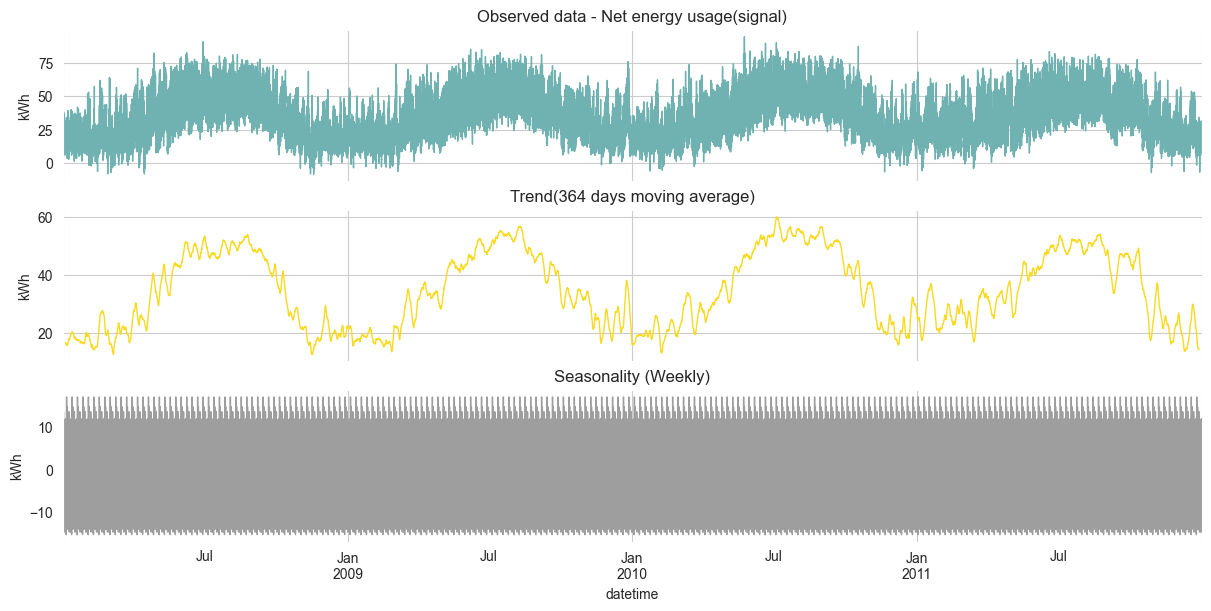

In [245]:
# Decomposition weekly (7 days)
decomp_weekly = seasonal_decompose(df.set_index('datetime')['net_load_kWh'], model='add', 
    two_sided = True,period=7*24)
# decomp_weekly.plot();
# plot_decomposition(decomp)
plot_decomposition(decomp_weekly, labels = ['Observed data - Net energy usage(signal)',
                    'Trend(364 days moving average)', 'Seasonality (Weekly)',
                    'Residual'],
                    file_name = '../images/decomposition_weekly_net_energy_usage.png')

# fig.savefig('../images/decomposition_weekly_net_energy_usage.png', dpi=450, bbox_inches='tight')

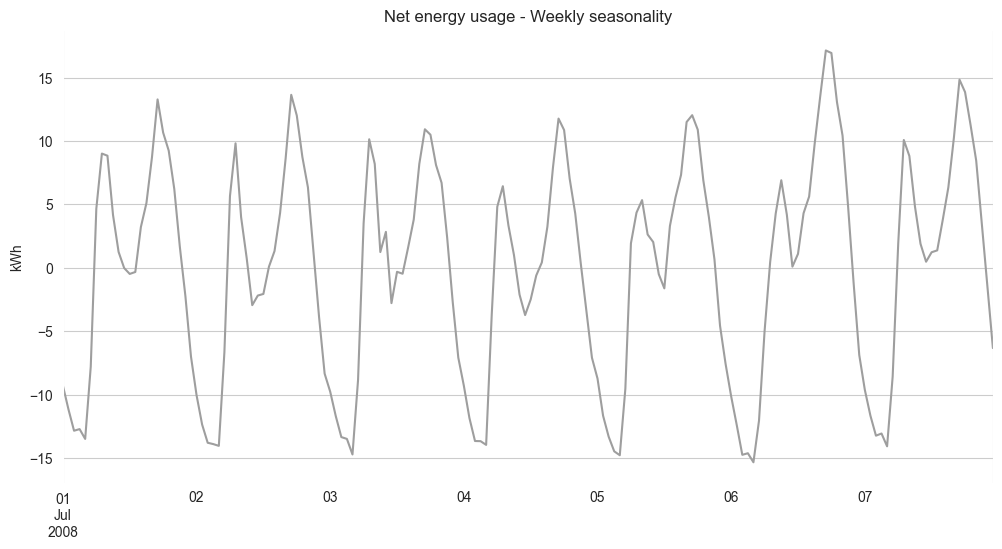

In [246]:
fig, ax = plt.subplots()
ax = decomp_weekly.seasonal[181*24:181*24+(24*7),].plot(color=COLOR_AUTUMN)
ax.set(title='Net energy usage - Weekly seasonality', xlabel='', ylabel='kWh')
fig.savefig('../images/weekly_seasonality_net_energy_usage.png', dpi=450, bbox_inches='tight')


## Decomposition of the time series (yearly)

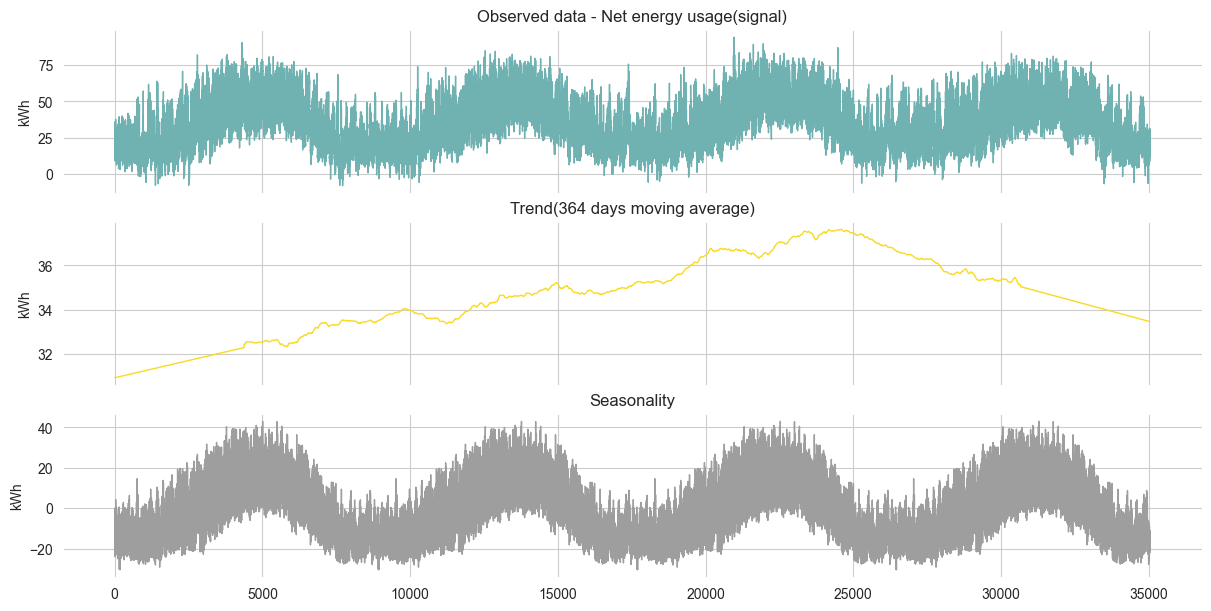

In [247]:
# Decomposition weekly (365 days)
decomp_yearly = seasonal_decompose(df['net_load_kWh'], model='add', 
    two_sided = True, period=365*24, extrapolate_trend=24*180)
# decomp_weekly.plot();
# plot_decomposition(decomp)
plot_decomposition(decomp_yearly, labels = ['Observed data - Net energy usage(signal)',
                    'Trend(364 days moving average)', 'Seasonality',
                    'Residual'],
                    file_name = '../images/decomposition_yearly_net_energy_usage.png')

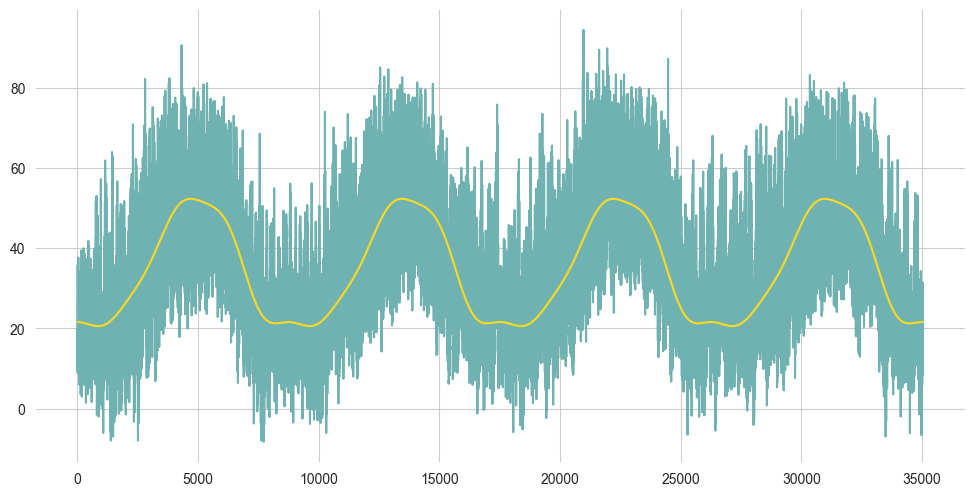

In [248]:
model,season = fit_tri(df['net_load_kWh'], 4)
plt.plot(df['net_load_kWh'])
plt.plot(season+model.intercept_)
df['season_Y'] = season

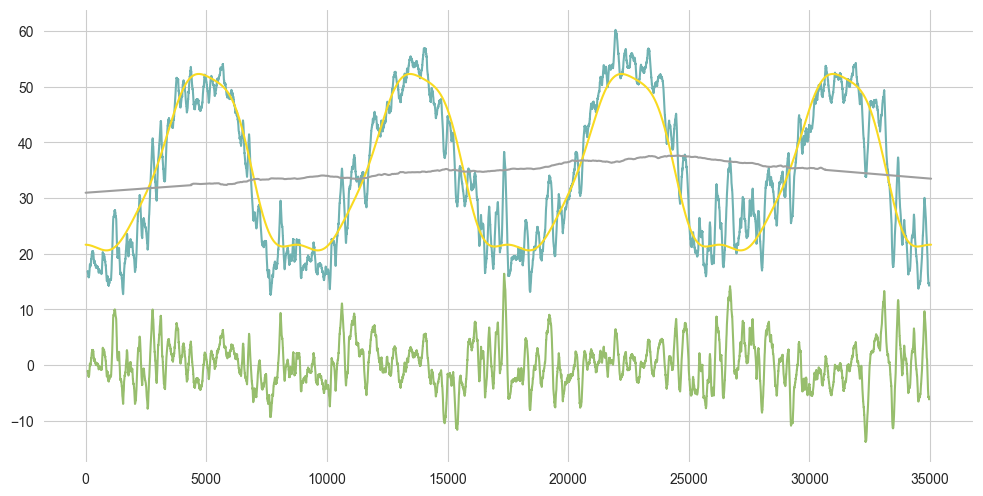

In [249]:
df['trend_Y'] = decomp_yearly.trend
df.head()
df['decom_Y'] = df['net_load_kWh'] - df['season_Y'] - df['trend_Y']
plt.plot(df['net_load_kWh'].rolling(24*7, center=True).mean())
plt.plot(df['season_Y']+model.intercept_)
plt.plot(df['trend_Y'])
plt.plot(df['decom_Y'].rolling(24*7, center = True).mean())


[Text(0.5, 1.0, 'Net energy usage - Yearly seasonality'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'kWh')]

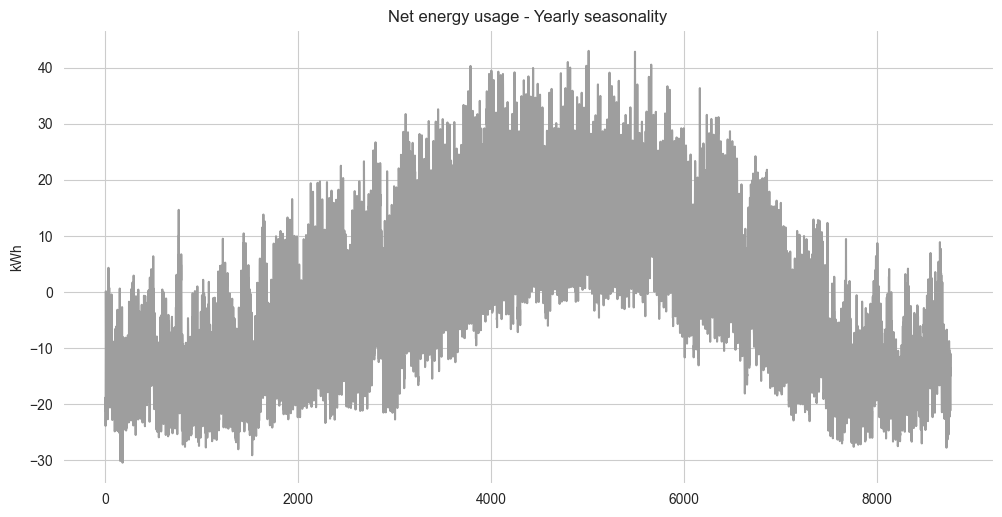

In [250]:
fig, ax = plt.subplots()
ax = decomp_yearly.seasonal[0:365*24,].plot(color=COLOR_AUTUMN)
ax.set(title='Net energy usage - Yearly seasonality', xlabel='', ylabel='kWh')
# fig.savefig('../images/yearly_seasonality_net_energy_usage.png', dpi=450, bbox_inches='tight')


In [251]:
df_decom_year = df.set_index('datetime')['net_load_kWh']- decomp_yearly.seasonal -decomp_yearly.trend
df_decom_year = pd.DataFrame(df_decom_year.dropna(), columns=['net_load_kWh'])
df_decom_year

,net_load_kWh


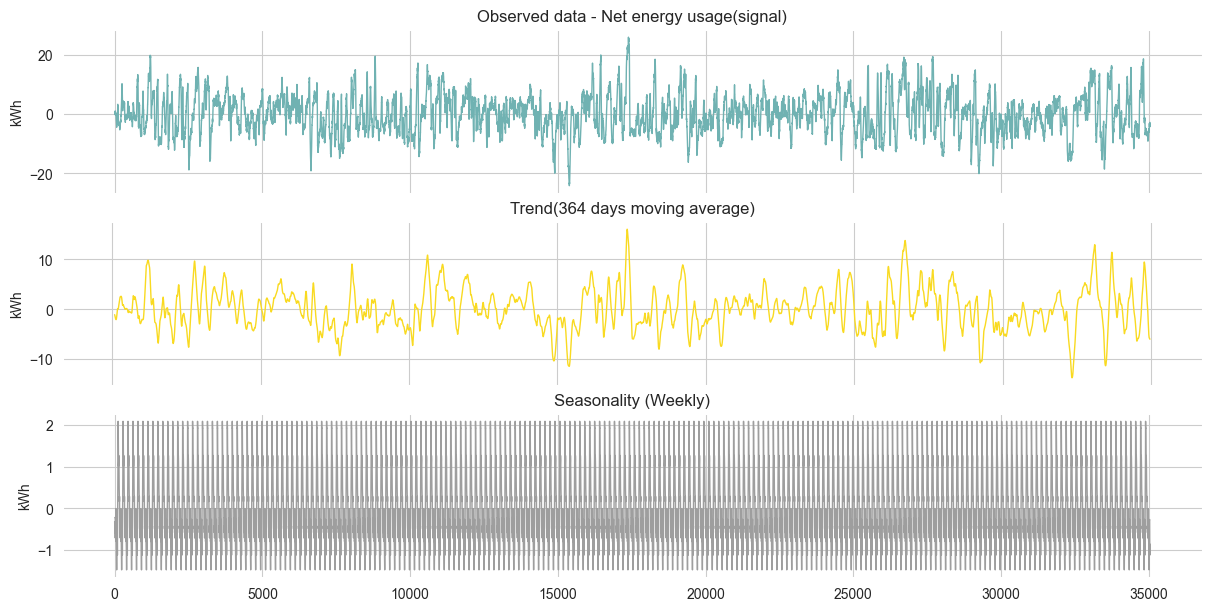

In [252]:
# Decomposition weekly (7 days)
decomp_weekly = seasonal_decompose(df['decom_Y'].rolling(24, center=True, min_periods=1).mean(), model='add', 
    two_sided = True,period=7*24)
# decomp_weekly.plot();
# plot_decomposition(decomp)
plot_decomposition(decomp_weekly, labels = ['Observed data - Net energy usage(signal)',
                    'Trend(364 days moving average)', 'Seasonality (Weekly)',
                    'Residual'],
                    file_name = '../images/decomposition_weekly_net_energy_usage.png')

# fig.savefig('../images/decomposition_weekly_net_energy_usage.png', dpi=450, bbox_inches='tight')

In [253]:
decomp_weekly.seasonal.reset_index().iloc[181*24]

index       4344.000000
seasonal       1.153183
Name: 4344, dtype: float64

[Text(0.5, 1.0, 'Net energy usage - Weekly seasonality'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'kWh')]

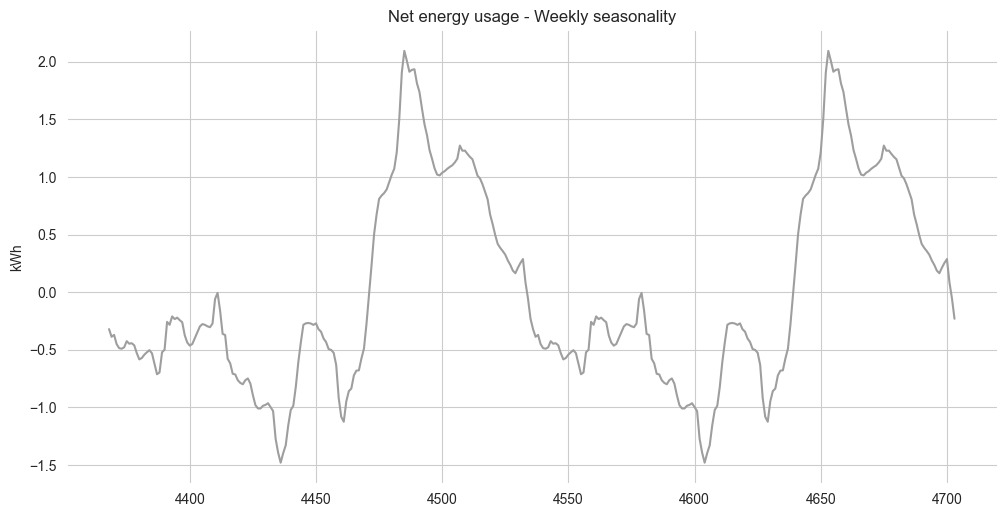

In [254]:
fig, ax = plt.subplots()
ax = decomp_weekly.seasonal[182*24:182*24+(24*14),].plot(color=COLOR_AUTUMN)
ax.set(title='Net energy usage - Weekly seasonality', xlabel='', ylabel='kWh')
# fig.savefig('../images/weekly_seasonality_net_energy_usage.png', dpi=450, bbox_inches='tight')

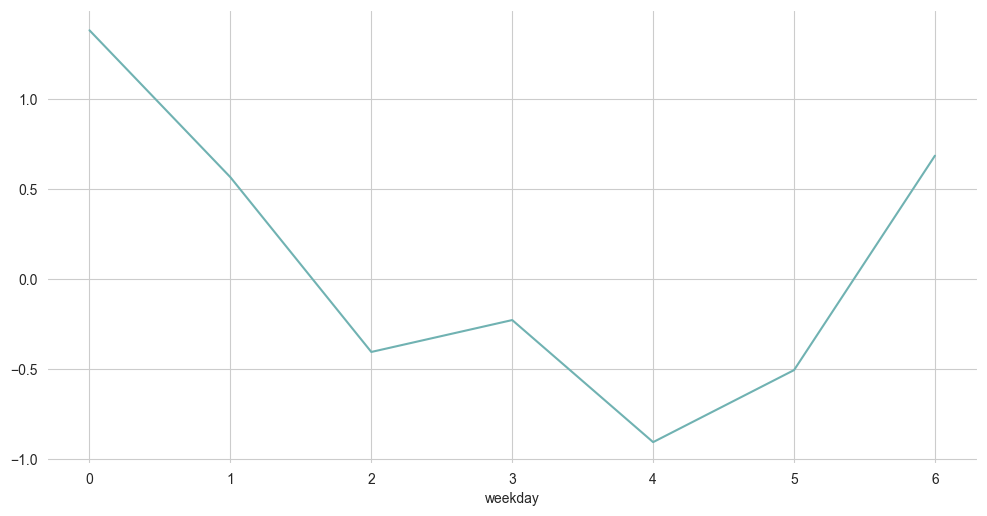

In [255]:
# df['decom_Y']
df['date'] = df.datetime.dt.date
df['weekday'] = df.datetime.dt.weekday
df.groupby('date').mean()['decom_Y']
df['daily_rolling'] = df['decom_Y'].rolling(24, center=True, min_periods=1).mean()
df.groupby('weekday').mean()['daily_rolling'].plot()
daily_rolling = df.groupby('weekday').mean()['daily_rolling'].to_numpy()

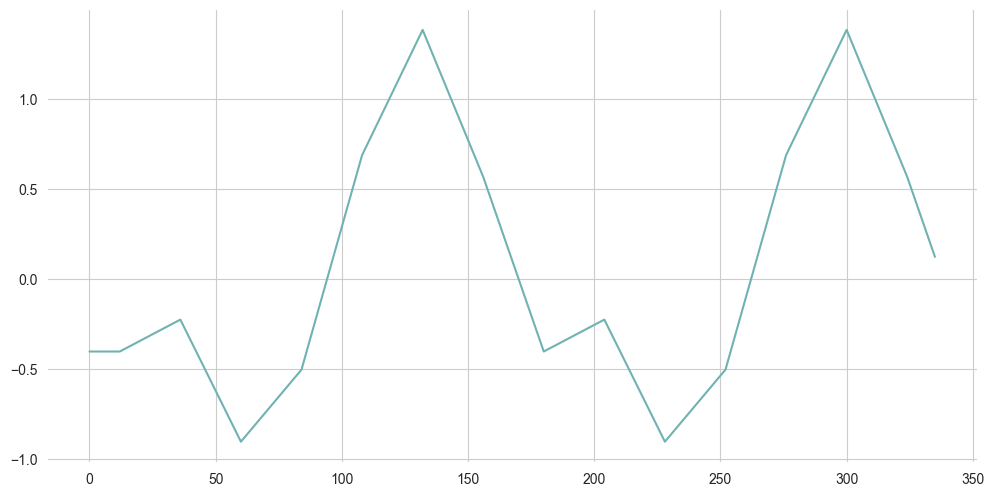

In [256]:
df['season_W'] = df['weekday'].map(lambda x:daily_rolling[x]).rolling(24, center=True, min_periods=1).mean()
df['season_W'][0:24*14].plot()
df['decom_W'] = df['decom_Y']-df['season_W']

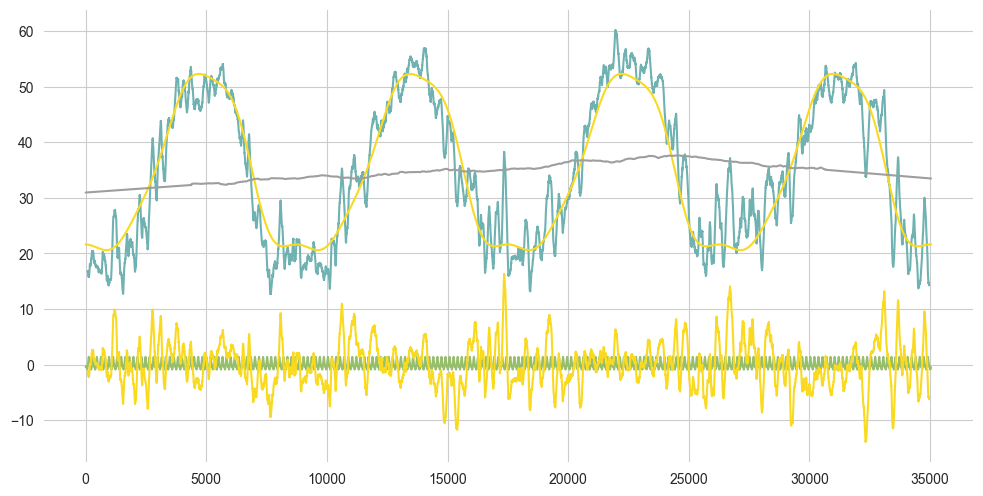

In [257]:
plt.plot(df['net_load_kWh'].rolling(24*7, center=True).mean())
plt.plot(df['season_Y']+model.intercept_)

plt.plot(df['trend_Y'])
plt.plot(df['season_W'])
plt.plot(df['decom_W'].rolling(24*7, center = True).mean())

<AxesSubplot:>

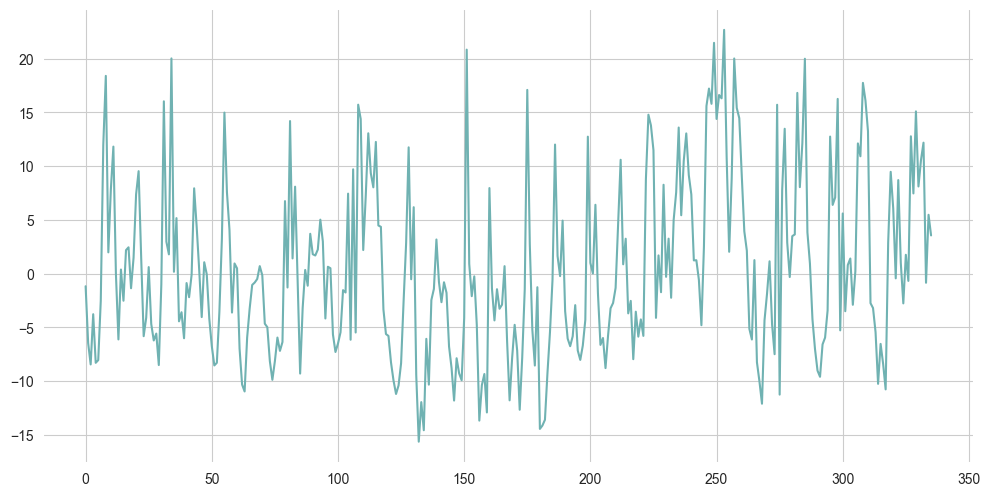

In [260]:
df[0:24*14]['decom_W'].plot()

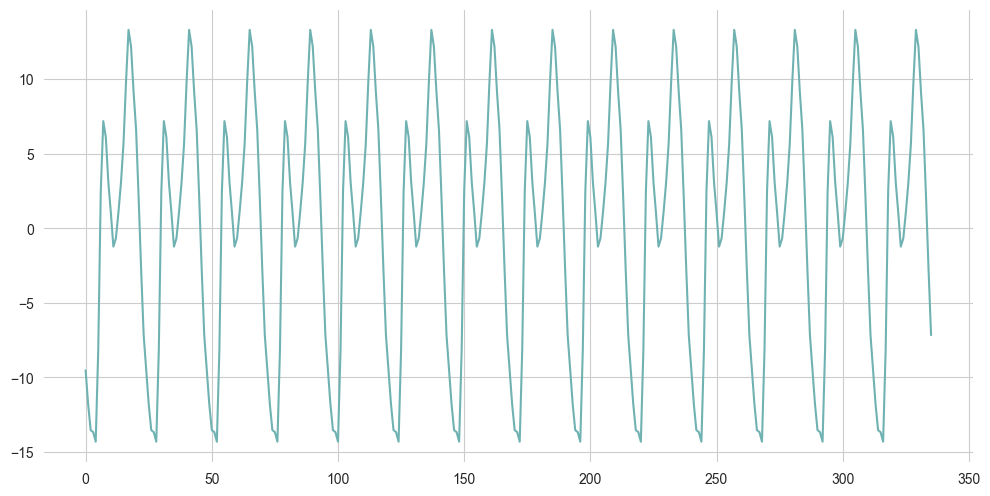

In [266]:
df['hour'] = df.datetime.dt.hour
hourly_rolling = df.groupby('hour').mean()['decom_W'].to_numpy()
df['hourly_rolling'] = df['hour'].map(lambda x:hourly_rolling[x])
df[0:24*14]['hourly_rolling'].plot()
df['decom_H'] = df['decom_W'] - df['hourly_rolling']

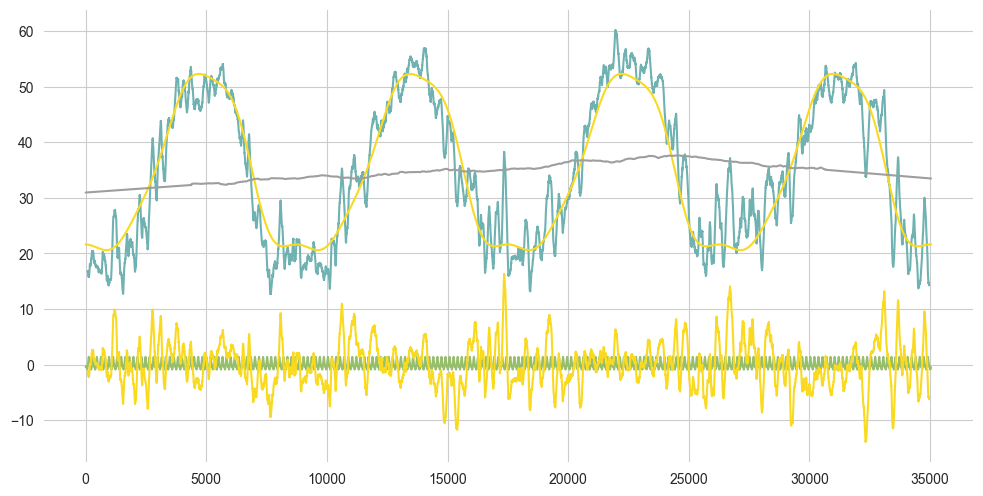

In [268]:
plt.plot(df['net_load_kWh'].rolling(24*7, center=True).mean())
plt.plot(df['season_Y']+model.intercept_)

plt.plot(df['trend_Y'])
plt.plot(df['season_W'])

plt.plot(df['decom_W'].rolling(24*7, center = True).mean())

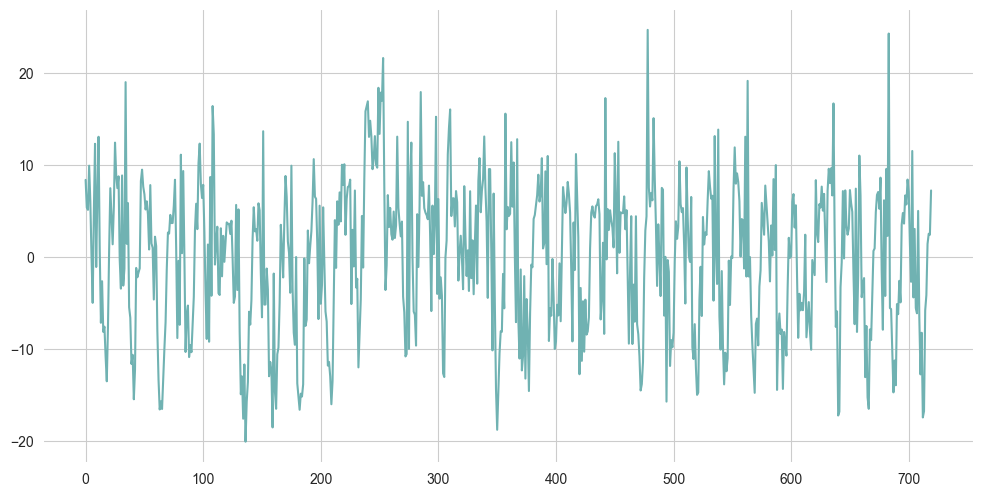

In [271]:
plt.plot(df[0:24*30]['decom_H'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2835f0340>,
 'caps': [<matplotlib.lines.Line2D at 0x2835f0e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x283e4e490>],
 'medians': [<matplotlib.lines.Line2D at 0x2835f04f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2835f08e0>],
 'means': []}

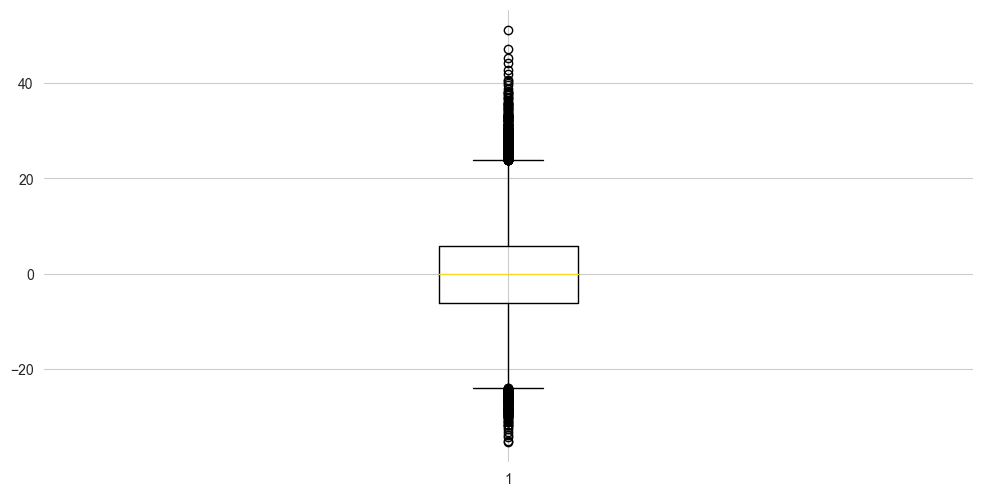

In [270]:
plt.boxplot(data=df, x='decom_H')